In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from matplotlib import pyplot
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk import word_tokenize
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report
import tensorflow as tf
import re
import torchtext
import random
import os

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    #added
    torch.cuda.manual_seed_all(seed)
    # When running on the CuDNN backend
    torch.backends.cudnn.deterministic = True
seed_everything()

In [4]:
testset = pd.read_csv("/content/gdrive/My Drive/project/HASOCData/hasoc2019_en_test-2919.tsv",sep='\t')
trainset = pd.read_csv("/content/gdrive/My Drive/project/HASOCData/english_dataset.tsv",sep="\t")

In [5]:
#check for missing data
print(trainset.isna().sum())
print(testset.isna().sum())

id        0
tweet     0
task_1    0
task_2    0
task_3    0
dtype: int64
id        0
tweet     0
task_1    0
task_2    0
task_3    0
dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


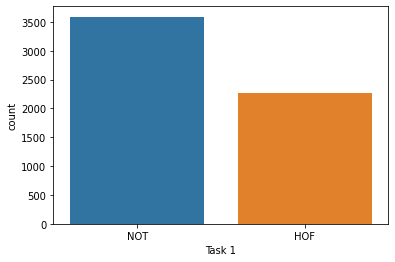

In [6]:
import seaborn as sns

sns.countplot(trainset.task_1)
pyplot.xlabel('Task 1');

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


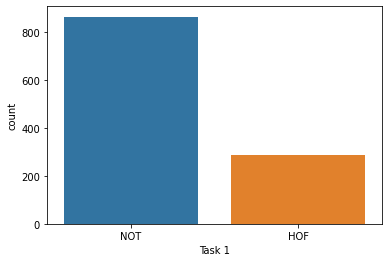

In [7]:
import seaborn as sns

sns.countplot(testset.task_1)
pyplot.xlabel('Task 1');

In [8]:
print(trainset.head())
print(len(trainset),len(testset))

           id                                              tweet  ... task_2 task_3
0  hasoc_en_1  #DhoniKeepsTheGlove | WATCH: Sports Minister K...  ...   NONE   NONE
1  hasoc_en_2  @politico No. We should remember very clearly ...  ...   HATE    TIN
2  hasoc_en_3  @cricketworldcup Guess who would be the winner...  ...   NONE   NONE
3  hasoc_en_4  Corbyn is too politically intellectual for #Bo...  ...   NONE   NONE
4  hasoc_en_5  All the best to #TeamIndia for another swimmin...  ...   NONE   NONE

[5 rows x 5 columns]
5852 1153


In [ ]:
'''def preprocess_pandas(data):
    data['tweet'] = data['tweet'].str.lower()
    data['tweet'] = data['tweet'].replace('[a-zA-Z0-9-_.]+@[a-zA-Z0-9-_.]+', '', regex=True)                      # remove emails
    data['tweet'] = data['tweet'].replace('((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.|$)){4}', '', regex=True)    # remove IP address
    data['tweet'] = data['tweet'].str.replace('[^\w\s]','')                                                       # remove special characters
    data['tweet'] = data['tweet'].replace('\d', '', regex=True)                                                   # remove numbers

    return data'''


In [9]:
def preprocess_pandas(data):
  #Step - a

  # Modify URLs to <url>
  data['tweet'] = [re.sub(r"([^ ]+(?<=\.[a-z]{3}))", "URL", entry) for entry in data['tweet']]

  # Step - b : Change all the text to lower case. This is required as python interprets 'dog' and 'DOG' differently
  data['tweet'] = [entry.lower() for entry in data['tweet']]

  # remove hashtag
  data['tweet'] = [re.sub("#","", entry) for entry in data['tweet']]


   # Step - c : replace username with @user
 
  data['tweet']=[re.sub(r"\B@\w+", "@user", entry) for entry in data['tweet']]
 # remove special characters


In [10]:
min_len = trainset[trainset['tweet'].str.len() == trainset['tweet'].str.len().min()]
print(min_len)

                 id           tweet task_1 task_2 task_3
2470  hasoc_en_2471  Are you crazy?    NOT   NONE   NONE


In [11]:
total=[trainset,testset]
#Ignoring indexes on the concatenation axis¶
total_data=pd.concat(total, ignore_index=True, sort=False)
preprocess_pandas(trainset)                             # pre-process
print(trainset.head())
print(len(trainset))

           id                                              tweet  ... task_2 task_3
0  hasoc_en_1  dhonikeepstheglove | watch: sports minister ki...  ...   NONE   NONE
1  hasoc_en_2  @user no. we should remember very clearly that...  ...   HATE    TIN
2  hasoc_en_3  @user guess who would be the winner of this cw...  ...   NONE   NONE
3  hasoc_en_4  corbyn is too politically intellectual for bor...  ...   NONE   NONE
4  hasoc_en_5  all the best to teamindia for another swimming...  ...   NONE   NONE

[5 rows x 5 columns]
5852


In [12]:
sentences = total_data['tweet']
#sentences = data_train['tweet']
sentences=list(sentences)

In [13]:
words=[]
for sent in list(sentences):
    words.append(sent.split())#list of word

In [14]:
words = [val for sublist in words for val in sublist]#convert lists of word into one big list


In [15]:
from collections import Counter

## Build a dictionary that maps words to integers
counts = Counter(words)
vocab = sorted(counts, key=counts.get, reverse=True)
vocab_to_int = {word: ii for ii, word in enumerate(vocab, 1)}#ii  will start from one word will start from the most common in vpcab 

## use the dict to tokenize each review in reviews_split
## store the tokenized reviews in reviews_ints
tweets_ints = []
for tweet in sentences:
    tweets_ints.append([vocab_to_int[word] for word in tweet.split()])

In [16]:
# stats about vocabulary
print('Unique words: ', len((vocab_to_int)))  # 
print()

# print tokens in first review
print('Tokenized review: \n', tweets_ints[:1])

Unique words:  38206

Tokenized review: 
 [[28, 291, 11250, 3277, 447, 11251, 11252, 861, 1902, 1576, 925, 212, 101, 11253, 11254, 1344, 823, 2, 108, 72, 1, 507, 16, 78, 6, 226, 349, 7, 1, 87, 30, 11255, 655, 5, 2405, 11256]]


In [17]:
len(tweets_ints)

7005

In [18]:
# get rid from zero length word and find the length for the 
#outlier review stats
tweet_lens = Counter([len(x) for x in tweets_ints])
print("Zero-length reviews: {}".format(tweet_lens[0]))
print("Maximum review length: {}".format(max(tweet_lens)))

Zero-length reviews: 0
Maximum review length: 95


In [19]:
#so we must make all review in shape of 30(Maximum review length)
#remove any zero length review 
non_zero_idx = [ii for ii, review in enumerate(tweets_ints) if len(review) != 0]
tweets_ints = [tweets_ints[ii] for ii in non_zero_idx]
#dont forget to remove the corresponding  label also
#encoded_labels = np.array([encoded_labels[ii] for ii in non_zero_idx])

In [ ]:
#padding small reviwe(smallest than sequence lengh ) with zero from the left and for the longest Review  (largest than sequence lengh ) 

In [ ]:
#our sequence will be in size of 30(the maximum length of the review )

In [20]:
def pad_features(tweets_ints, seq_length):
    ''' Return features of review_ints, where each review is padded with 0's 
        or truncated to the input seq_length.
    '''
    
    # getting the correct rows x cols shape
    features = np.zeros((len(tweets_ints), seq_length), dtype=int)

    # for each review, I grab that review and 
    for i, row in enumerate(tweets_ints):
        features[i, -len(row):] = np.array(row)#kepp pading zero untill you reach the lengh of review from the last 
    
    return features#our transformed review to the standard review length 

In [21]:
# Test our implementation!

seq_length = 96

features = pad_features(tweets_ints, seq_length=seq_length)

## test statements - do not change - ##
assert len(features)==len(tweets_ints), "Your features should have as many rows as reviews."
assert len(features[0])==seq_length, "Each feature row should contain seq_length values."

# print first 10 values of the first 30 batches 
print(features[:1,:])#print only the first row 

[[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
     28   291 11250  3277   447 11251 11252   861  1902  1576   925   212
    101 11253 11254  1344   823     2   108    72     1   507    16    78
      6   226   349     7     1    87    30 11255   655     5  2405 11256]]


In [22]:
features.shape

(7005, 96)

In [23]:
labels=total_data['task_1']
#labels=trainset['task_1']

In [24]:
 print(labels[0])

NOT


In [25]:
##if your review in posetive/negative form , but we will not need this 
## 1=HOF, 0=NOT label conversion
#labels_split = labels.split('\n')
encoded_labels = np.array([1 if label == 'HOF' else 0 for label in labels])
print(encoded_labels[0])

0


In [26]:
 split_frac = 0.84

## split data into training, validation, and test data (features and labels, x and y)

split_idx = int(len(features)*split_frac)
train_x, remaining_x = features[:split_idx], features[split_idx:]
train_y, remaining_y = encoded_labels[:split_idx], encoded_labels[split_idx:]

test_idx = int(len(remaining_x)*0.5)
val_x, test_x = remaining_x[:test_idx], remaining_x[test_idx:]
val_y, test_y = remaining_y[:test_idx], remaining_y[test_idx:]

## print out the shapes of your resultant feature data
print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))
print(type(train_x),type(test_y))

			Feature Shapes:
Train set: 		(5884, 96) 
Validation set: 	(560, 96) 
Test set: 		(561, 96)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [27]:
def ToLabel(df):

  #get  unique labels from category
  labels = df.task_1.unique()#  you can use labels = set(df['category']) 
  #print(labels)# {sad', 'disgust', 'surprise', 'not-relevant', 'happy', 'angry'}

  #Build  a dictionary  to map emotions to integer
  emo2int = {}
  for index, label in enumerate(labels):#enumerate() takes iterator (set,list,dic,..etc)and returns tuple of index and the value 
      emo2int[label] = index 
  #replace 
  #dataframe.replace() function is used to replace a string, regex, list, dictionary, series, number etc. from a dataframe
  df['label'] = df.task_1.replace(emo2int)

In [ ]:
'''#second method
# Tokenize the sentences
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
testset = pd.read_csv("/content/gdrive/My Drive/project/HASOCData/hasoc2019_en_test-2919.tsv",sep='\t')
trainset = pd.read_csv("/content/gdrive/My Drive/project/HASOCData/english_dataset.tsv",sep="\t")

preprocess_pandas(testset)                             # pre-process
preprocess_pandas(trainset)                             # pre-process
maxlen=95
max_features=38206
train_x = trainset["tweet"].fillna("_##_").values
test_x = testset["tweet"].fillna("_##_").values

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_x))
train_x = tokenizer.texts_to_sequences(train_x)
test_x = tokenizer.texts_to_sequences(test_x)

# Pad the sentences 
train_x = pad_sequences(train_x, maxlen=maxlen)
test_x = pad_sequences(test_x, maxlen=maxlen)

# Get the target values
ToLabel(trainset)
ToLabel(testset)

 
train_y = trainset['label'].values
test_y = testset['label'].values'''

In [ ]:
trainset.head()

,id,tweet,task_1,task_2,task_3,label
0,hasoc_en_1,dhonikeepstheglove | watch: sports minister ki...,NOT,NONE,NONE,0
1,hasoc_en_2,@user no. we should remember very clearly that...,HOF,HATE,TIN,1
2,hasoc_en_3,@user guess who would be the winner of this cw...,NOT,NONE,NONE,0
3,hasoc_en_4,corbyn is too politically intellectual for bor...,NOT,NONE,NONE,0
4,hasoc_en_5,all the best to teamindia for another swimming...,NOT,NONE,NONE,0


In [28]:
testset.head()

,id,tweet,task_1,task_2,task_3
0,hasoc_en_902,West Bengal Doctor Crisis: Protesting doctors ...,NOT,NONE,NONE
1,hasoc_en_416,68.5 million people have been forced to leave ...,NOT,NONE,NONE
2,hasoc_en_207,"You came, you saw .... we will look after the ...",NOT,NONE,NONE
3,hasoc_en_595,We'll get Brexit delivered by October 31st. ...,NOT,NONE,NONE
4,hasoc_en_568,Fuck you. Go back to the dark ages you cow @IB...,HOF,PRFN,UNT


In [31]:
max_feature=len(vocab_to_int)

In [32]:
max_features=max_feature+1

def load_glove(word_index):
    words_found=0
    EMBEDDING_FILE = '/content/gdrive/My Drive/project/glove.840B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:300]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))
    
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]

    # word_index = tokenizer.word_index
    nb_words = min(max_features, len(word_index)+1)
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
           embedding_matrix[i] = embedding_vector
           words_found += 1

            
    return embedding_matrix,words_found

    
 

In [33]:
embedding_matrix1,words_found=load_glove(vocab_to_int)
print(len(embedding_matrix1),words_found)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


38207 16482


In [34]:
embedding_matrix1.shape

(38207, 300)

In [35]:
import torch
from torch.utils.data import TensorDataset, DataLoader



In [36]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x),torch.Tensor(train_y))
valid_data = TensorDataset(torch.from_numpy(val_x),torch.Tensor(val_y))
test_data = TensorDataset(torch.from_numpy(test_x),torch.Tensor(test_y))

# dataloaders

#train_data = TensorDataset(torch.from_numpy(features),torch.Tensor(encoded_labels))
#train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

batch_size = 50

# make sure the SHUFFLE your training data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, drop_last=True)

torch.Size([50, 95])


In [37]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([50, 96])
Sample input: 
 tensor([[    0,     0,     0,  ...,    28,   197,   168],
        [    0,     0,     0,  ...,    21,   179, 13391],
        [    0,     0,     0,  ..., 24181,    17,  9907],
        ...,
        [    0,     0,     0,  ...,     3,  2212,    29],
        [    0,     0,     0,  ...,  9467,    17,  4823],
        [    0,     0,     0,  ...,    48,  4365,    19]])

Sample label size:  torch.Size([50])
Sample label: 
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0.,
        0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0.,
        0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1.])


In [ ]:
# building the model

In [38]:
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

No GPU available, training on CPU.


In [39]:
embedding_matrix1.shape

(38207, 300)

In [40]:
import torch.nn as nn

class HateDetectiontRNN(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super().__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix1, dtype=torch.float32))
        self.embedding.weight.requires_grad = True
        
        self.embedding_dropout = nn.Dropout2d(0.1)
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
        
        # linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()
        

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        # embeddings and lstm_out
        x = x.long()
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
    
        # stack up lstm outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden

In [41]:
vocab_size = len(vocab_to_int)+1 # +1 for the 0 padding + our word tokens
output_size = 1
embedding_dim = 300
hidden_dim = 200
n_layers = 1
 
net = HateDetectiontRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

print(net)

HateDetectiontRNN(
  (embedding): Embedding(38207, 300)
  (embedding_dropout): Dropout2d(p=0.1, inplace=False)
  (lstm): LSTM(300, 200, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=200, out_features=1, bias=True)
  (sig): Sigmoid()
)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [42]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [43]:
lr=0.01
 
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

In [44]:
 # training params

epochs = 4 # 3-4 is approx where I noticed the validation loss stop decreasing
valid_loss_min = np.Inf
counter = 0
print_every = 20
clip=5 # gradient clipping

# move model to GPU, if available
if(train_on_gpu):
    net.cuda()

net.train()
# train for some number of epochs
for e in range(epochs):
    # initialize hidden state
    h = net.init_hidden(batch_size)

    # batch loop
    for inputs, labels in train_loader:
        counter += 1

        if(train_on_gpu):
            inputs, labels = inputs.to(device), labels.to(device)

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        # zero accumulated gradients
        net.zero_grad()

        # get the output from the model
        output, h = net(inputs, h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        # loss stats
        if counter % print_every == 0:
            # Get validation loss
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            for inputs, labels in valid_loader:

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                val_h = tuple([each.data for each in val_h])

                if(train_on_gpu):
                    inputs, labels = inputs.cuda(), labels.cuda()

                output, val_h = net(inputs, val_h)
                val_loss = criterion(output.squeeze(), labels.float())

                val_losses.append(val_loss.item())

            net.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))
            if val_loss <= valid_loss_min:
                torch.save(net.state_dict(), '/content/gdrive/My Drive/project/model_HST_glove_learning_best.pt')
                valid_loss_min = val_loss


Epoch: 1/4... Step: 20... Loss: 0.829617... Val Loss: 0.606222
Epoch: 1/4... Step: 40... Loss: 0.702243... Val Loss: 0.621356
Epoch: 1/4... Step: 60... Loss: 0.581934... Val Loss: 0.606345
Epoch: 1/4... Step: 80... Loss: 0.674916... Val Loss: 0.596782
Epoch: 1/4... Step: 100... Loss: 0.627561... Val Loss: 0.593558
Epoch: 2/4... Step: 120... Loss: 0.577040... Val Loss: 0.673811
Epoch: 2/4... Step: 140... Loss: 0.509129... Val Loss: 0.666156
Epoch: 2/4... Step: 160... Loss: 0.378085... Val Loss: 0.740865
Epoch: 2/4... Step: 180... Loss: 0.357346... Val Loss: 0.685833
Epoch: 2/4... Step: 200... Loss: 0.437292... Val Loss: 0.732368
Epoch: 2/4... Step: 220... Loss: 0.447960... Val Loss: 0.722526
Epoch: 3/4... Step: 240... Loss: 0.065988... Val Loss: 0.693920
Epoch: 3/4... Step: 260... Loss: 0.025205... Val Loss: 1.002926
Epoch: 3/4... Step: 280... Loss: 0.118139... Val Loss: 0.997918
Epoch: 3/4... Step: 300... Loss: 0.096737... Val Loss: 0.855958
Epoch: 3/4... Step: 320... Loss: 0.108942...

In [48]:
net = HateDetectiontRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
net.load_state_dict(torch.load('/content/gdrive/My Drive/project/model_HST_glove_learning_best.pt'))
 

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


<All keys matched successfully>

In [49]:
vocab_size = len(vocab_to_int)+1 # +1 for the 0 padding + our word tokens
output_size = 1
embedding_dim = 300
hidden_dim = 200
n_layers = 1
 

In [50]:
# Get test data loss and accuracy

test_losses = [] # track loss
num_correct = 0

# init hidden state
h = net.init_hidden(batch_size)

net.eval()
# iterate over test data
for inputs, labels in test_loader:

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    h = tuple([each.data for each in h])

    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()
    
    # get predicted outputs
    output, h = net(inputs, h)
    
    # calculate loss
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    
    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())  # rounds to the nearest integer
    
    # compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)


# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

Test loss: 0.747
Test accuracy: 0.693


In [51]:
x,y=next(iter(test_loader))

In [ ]:
x

tensor([[    0,     0,     0,  ...,  1174,   406, 35953],
        [    0,     0,     0,  ...,   798, 37033,   408],
        [    0,     0,     0,  ...,  1900,    82,  2778],
        ...,
        [    0,     0,     0,  ...,     2,    14, 35891],
        [    0,     0,     0,  ...,    72,  1951, 36183],
        [    0,     0,     0,  ...,     7,   526,  5922]])